## Setup

In [1]:
from IPython import get_ipython # type: ignore
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Standard imports
import os
import torch
import numpy as np
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import einops
from jaxtyping import Float, Int
from torch import Tensor

torch.set_grad_enabled(False)

# Device setup
GPU_TO_USE = 3

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = f"cuda:{GPU_TO_USE}" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# utility to clear variables out of the memory & and clearing cuda cache
import gc
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

Device: cuda:3


We'll set up our data directory (to store various SFC-related data) as the first child of the project root.
That is, `sfc-errors -> data`

In [2]:
from pathlib import Path
import sys
import os

def get_base_folder(project_root = "sfc-errors"):
	# Find the project root dynamically
	current_dir = os.getcwd()
	while True:
		if os.path.basename(current_dir) == project_root:  # Adjust to match your project root folder name
			break
		parent = os.path.dirname(current_dir)
		if parent == current_dir:  # Stop if we reach the system root (failsafe)
			raise RuntimeError(f"Project root {project_root} not found. Check your folder structure.")
		current_dir = parent

	return current_dir

def get_data_path(base_folder=None, data_folder_name='data'):
	if base_folder is None:
		base_folder = get_base_folder()

	return Path(base_folder) / data_folder_name

In [3]:
base_path = get_base_folder()
print(f"Base path: {base_path}")

sys.path.append(base_path)

Base path: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/sfc-errors


In [4]:
datapath = get_data_path(base_path) 
datapath

PosixPath('/mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/sfc-errors/data')

## Loading the model

We'll work with Gemma-2 2B (base version)

In [5]:
from sae_lens import SAE, HookedSAETransformer, ActivationsStore

USE_INSTRUCT = False
PARAMS_COUNT = 2

MODEL_NAME = f'gemma-2-{PARAMS_COUNT}b' + ('-it' if USE_INSTRUCT else '')
print(f'Using {MODEL_NAME}')

model = HookedSAETransformer.from_pretrained(MODEL_NAME, device=device, dtype=torch.bfloat16)
model

Using gemma-2-2b


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


HookedSAETransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-25): 26 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln1_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
      

## Loading the data

This uses my custom dataloader class, which parses raw data and prepares into a nice format for SFC, including providing some useful metadata such as token positions for where the answer should be, attention masks etc. The details of the class are convoluted because it was developed for a more general purpose than verb agreement tasks, so you can largely ignore the next few cells.

In [6]:
from classes.sfc_data_loader import SFCDatasetLoader
import utils.prompts as prompts
from utils.enums import *

In [7]:
DATASET_NAME = SupportedDatasets.VERB_AGREEMENT

dataloader = SFCDatasetLoader(DATASET_NAME, model,
                              local_dataset=True, base_folder_path=datapath)

In [8]:
clean_dataset, corrupted_dataset = dataloader.get_clean_corrupted_datasets(tokenize=True, apply_chat_template=False, prepend_generation_prefix=True)

Figuring out optimal padding length...
Filtered out 484 longest prompts from a total of 10560 prompts.
Setting max prompt length to 8


100%|██████████| 10076/10076 [00:15<00:00, 667.29it/s]


Corrupted dataset here refers to the collection of patched prompts and their answers (verb completions) in the SFC paper terminology.

In [9]:
CONTROL_SEQ_LEN = clean_dataset['control_sequence_length'][0].item() # how many first tokens to ignore when computing SFC scores
N_CONTEXT = clean_dataset['prompt'].shape[1]

CONTROL_SEQ_LEN, N_CONTEXT

(2, 8)

In [10]:
print('Clean dataset:')
for prompt in clean_dataset['prompt'][:3]:
  print("\nPrompt:", model.to_string(prompt), end='\n\n')

  for i, tok in enumerate(prompt):
    str_token = model.to_string(tok)
    print(f"({i-CONTROL_SEQ_LEN}, {str_token})", end=' ')
  print()

print('Corrupted dataset:')
for prompt in corrupted_dataset['prompt'][:3]:
  print("\nPrompt:", model.to_string(prompt), end='\n\n')
  
  for i, tok in enumerate(prompt):
    str_token = model.to_string(tok)
    print(f"({i-CONTROL_SEQ_LEN}, {str_token})", end=' ')
  print()

Clean dataset:

Prompt: <bos>The doctors that the executives like<pad>

(-2, <bos>) (-1, The) (0,  doctors) (1,  that) (2,  the) (3,  executives) (4,  like) (5, <pad>) 

Prompt: <bos>The fathers that the driver visits<pad>

(-2, <bos>) (-1, The) (0,  fathers) (1,  that) (2,  the) (3,  driver) (4,  visits) (5, <pad>) 

Prompt: <bos>The boys that the parents inform<pad>

(-2, <bos>) (-1, The) (0,  boys) (1,  that) (2,  the) (3,  parents) (4,  inform) (5, <pad>) 
Corrupted dataset:

Prompt: <bos>The doctor that the executives like<pad>

(-2, <bos>) (-1, The) (0,  doctor) (1,  that) (2,  the) (3,  executives) (4,  like) (5, <pad>) 

Prompt: <bos>The father that the driver visits<pad>

(-2, <bos>) (-1, The) (0,  father) (1,  that) (2,  the) (3,  driver) (4,  visits) (5, <pad>) 

Prompt: <bos>The boy that the parents inform<pad>

(-2, <bos>) (-1, The) (0,  boy) (1,  that) (2,  the) (3,  parents) (4,  inform) (5, <pad>) 


In [11]:
# Sanity checks

# Control sequence length must be the same for all samples in both datasets
clean_ds_control_len = clean_dataset['control_sequence_length']
corrupted_ds_control_len = corrupted_dataset['control_sequence_length']

assert torch.all(corrupted_ds_control_len == corrupted_ds_control_len[0]), "Control sequence length is not the same for all samples in the dataset"
assert torch.all(clean_ds_control_len == clean_ds_control_len[0]), "Control sequence length is not the same for all samples in the dataset"
assert clean_ds_control_len[0] == corrupted_ds_control_len[0], "Control sequence length is not the same for clean and corrupted samples in the dataset"
assert clean_dataset['answer'].max().item() < model.cfg.d_vocab, "Clean answers exceed vocab size"
assert corrupted_dataset['answer'].max().item() < model.cfg.d_vocab, "Patched answers exceed vocab size"
assert (clean_dataset['answer_pos'] < N_CONTEXT).all().item(), "Answer positions exceed logits length"
assert (corrupted_dataset['answer_pos'] < N_CONTEXT).all().item(), "Answer positions exceed logits length"

# Setting up the SAEs

In [12]:
from classes.sfc_model import *

RUN_WITH_SAES = True # we'll run the model with attached SAEs to automatically compute error scores and patch w.r.t. them

# So there will be no caching device (everything we'll be done on a single GPU)
if RUN_WITH_SAES:
    caching_device = device 
else:
    caching_device = "cuda:2"


caching_device

'cuda:3'

I'll use my custom `SFC_Gemma` class. In short, it
- Loads a Gemma model and its Gemma Scope SAEs (either attaching them to the model or not)
- Provides interface methods for computing SFC scores **and activation patching** scores

In [ ]:
clear_cache()

sfc_model = SFC_Gemma(model, params_count=PARAMS_COUNT, control_seq_len=CONTROL_SEQ_LEN, 
                      attach_saes=RUN_WITH_SAES, caching_device=caching_device)
sfc_model.print_saes()

clear_cache()

# sfc_model.model.cfg
# , sfc_model.saes[0].cfg.dtype

# Activation patching

Here we'll compute the SFC scores for all of the SAE nodes (although we'll be mainly interested in the error nodes)

In [14]:
batch_size = 900
total_batches = None

# Reset the hooks to avoid weird bugs
sfc_model.model.reset_hooks()
if RUN_WITH_SAES:
    sfc_model._reset_sae_hooks()
clear_cache()

# Compute the patching effects for each type of error (resid, mlp, attn)
patching_effects = sfc_model.compute_act_patching_scores_for_errors(clean_dataset, corrupted_dataset, 
																	batch_size=batch_size, total_batches=total_batches)

patching_effects.keys()

---
Samples 0/10076
---
Computing patching effect for resid errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for mlp errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for attn errors...


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 900/10076
---
Computing patching effect for resid errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for mlp errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for attn errors...


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 1800/10076
---
Computing patching effect for resid errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for mlp errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for attn errors...


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 2700/10076
---
Computing patching effect for resid errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for mlp errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for attn errors...


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 3600/10076
---
Computing patching effect for resid errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for mlp errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for attn errors...


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 4500/10076
---
Computing patching effect for resid errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for mlp errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for attn errors...


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 5400/10076
---
Computing patching effect for resid errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for mlp errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for attn errors...


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 6300/10076
---
Computing patching effect for resid errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for mlp errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for attn errors...


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 7200/10076
---
Computing patching effect for resid errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for mlp errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for attn errors...


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 8100/10076
---
Computing patching effect for resid errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for mlp errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for attn errors...


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 9000/10076
---
Computing patching effect for resid errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for mlp errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for attn errors...


  0%|          | 0/26 [00:00<?, ?it/s]

---
Samples 9900/10076
---
Computing patching effect for resid errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for mlp errors...


  0%|          | 0/26 [00:00<?, ?it/s]

Computing patching effect for attn errors...


  0%|          | 0/26 [00:00<?, ?it/s]

dict_keys(['resid', 'mlp', 'attn'])

In [15]:
# Each error type should have the number of "patching effects" equal to the number of layers
patching_effects['resid'].shape, patching_effects['mlp'].shape, patching_effects['attn'].shape 

(torch.Size([26, 8]), torch.Size([26, 8]), torch.Size([26, 8]))

In [16]:
def save_dict(data_dict, dataset_name='sva', prefix=''):   
    filename = f'{dataset_name}_{prefix}_act_patching_scores.pkl'
     
    print(f'Saving {filename}...')
    filename = datapath / filename

    # Save using torch.save, which properly handles tensor storage details
    torch.save(data_dict, filename)

In [17]:
save_dict(patching_effects['resid'], prefix='resid') # don't aggregate the tokens because verb-agreement is token-specific dataset
save_dict(patching_effects['mlp'], prefix='mlp') 
save_dict(patching_effects['attn'], prefix='attn') 

Saving sva_resid_act_patching_scores.pkl...
Saving sva_mlp_act_patching_scores.pkl...
Saving sva_attn_act_patching_scores.pkl...


# Patching results analysis

#### Setup x2 for running the notebook from this section (don't read)

In [1]:
from IPython import get_ipython # type: ignore
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Standard imports
import os
import torch
import numpy as np
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import einops
from jaxtyping import Float, Int
from torch import Tensor

torch.set_grad_enabled(False)

# Device setup
GPU_TO_USE = 3

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = f"cuda:{GPU_TO_USE}" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# utility to clear variables out of the memory & and clearing cuda cache
import gc
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

from pathlib import Path
import sys
import os

def get_base_folder(parent_dir_name = "sfc-errors"):
	# Find the project root dynamically
	current_dir = os.getcwd()
	while True:
		if os.path.basename(current_dir) == parent_dir_name:  # Adjust to match your project root folder name
			break
		parent = os.path.dirname(current_dir)
		if parent == current_dir:  # Stop if we reach the system root (failsafe)
			raise RuntimeError(f"Project root {parent_dir_name} not found. Check your folder structure.")
		current_dir = parent

	return current_dir

def get_data_path(base_folder=None, data_folder_name='data'):
	if base_folder is None:
		base_folder = get_base_folder()

	return Path(base_folder) / data_folder_name

base_path = get_base_folder()
print(f"Base path: {base_path}")

# Add the parent directory (sfc_deception) to sys.path
sys.path.append(base_path)

datapath = get_data_path(base_path) 
datapath

Device: cuda:3
Base path: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/sfc-errors


PosixPath('/mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/sfc-errors/data')

Load error node scores:
- SFC scores (attribution patching)
- Activation patching scores

In [18]:
def load_act_patching_scores(dataset_name='sva', prefix=''):
    filename = f'{dataset_name}_{prefix}_act_patching_scores.pkl'
    print(f'Loading {filename}...')
    filename = datapath / filename

    # Use torch.load with map_location to force loading on the desired device
    data_dict = torch.load(filename, map_location=torch.device(device))
    return data_dict

def load_sfc_scores(nodes_prefix='rc_dataset', aggregated_tokens=True, device=device):
    aggregation_type = 'All_tokens' if aggregated_tokens else 'None'
    if nodes_prefix:
        filename = f'{aggregation_type}_agg_{nodes_prefix}_scores.pkl'
    else:
        filename = f'{aggregation_type}_agg_scores.pkl'
    
    print(f'Loading {filename}...')
    filename = datapath / filename

    # Use torch.load with map_location to force loading on the desired device
    data_dict = torch.load(filename, map_location=torch.device(device))
    return data_dict


sfc_scores = load_sfc_scores(aggregated_tokens=False)

resid_patching_scores = load_act_patching_scores(prefix='resid')
mlp_patching_scores = load_act_patching_scores(prefix='mlp') 
attn_patching_scores = load_act_patching_scores(prefix='attn') 

resid_patching_scores.shape, mlp_patching_scores.shape, attn_patching_scores.shape

Loading None_agg_rc_dataset_scores.pkl...
Loading sva_resid_act_patching_scores.pkl...
Loading sva_mlp_act_patching_scores.pkl...
Loading sva_attn_act_patching_scores.pkl...


(torch.Size([26, 8]), torch.Size([26, 8]), torch.Size([26, 8]))

In [26]:
N_LAYERS = 26 

# Extract the error scores from the scores of all SFC nodes
resid_sfc_scores = [sfc_scores[f'blocks.{k}.hook_resid_post.hook_sae_error'] for k in range(N_LAYERS)]
mlp_sfc_scores = [sfc_scores[f'blocks.{k}.hook_mlp_out.hook_sae_error'] for k in range(N_LAYERS)]
attn_sfc_scores = [sfc_scores[f'blocks.{k}.attn.hook_z.hook_sae_error'] for k in range(N_LAYERS)]

In [27]:
# Compute mean SFC and act patching values **across tokens**
resid_sfc_values = [tensor.mean().float().cpu().numpy() for tensor in resid_sfc_scores]
mlp_sfc_values = [tensor.mean().float().cpu().numpy() for tensor in mlp_sfc_scores]
attn_sfc_values = [tensor.mean().float().cpu().numpy() for tensor in attn_sfc_scores]

resid_patching_values = [tensor.mean().float().cpu().numpy() for tensor in resid_patching_scores]
mlp_patching_values = [tensor.mean().float().cpu().numpy() for tensor in mlp_patching_scores]
attn_patching_values = [tensor.mean().float().cpu().numpy() for tensor in attn_patching_scores]

### Plotting all of the act-patching and SFC scores together

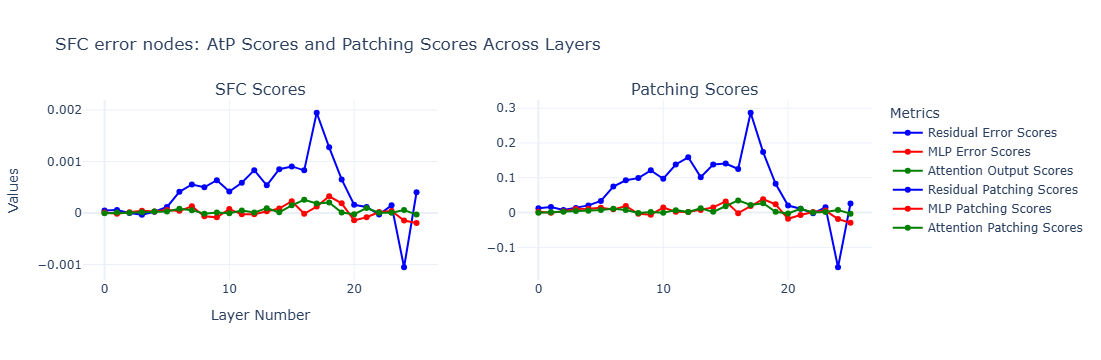

In [53]:
import plotly.graph_objects as go
import plotly.subplots as sp

# Layer indices representing layer numbers
layer_indices = list(range(len(resid_sfc_scores)))

# Create subplots
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("SFC Scores", "Patching Scores"))

# Define colors manually to ensure consistency
colors = {'Residual': 'blue', 'MLP': 'red', 'Attention': 'green'}

# Add Residual, MLP, and Attention Error Scores to first subplot
fig.add_trace(go.Scatter(
    x=layer_indices,
    y=resid_sfc_values,
    mode='lines+markers',
    name='Residual Error Scores',
    line=dict(color=colors['Residual'])
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=layer_indices,
    y=mlp_sfc_values,
    mode='lines+markers',
    name='MLP Error Scores',
    line=dict(color=colors['MLP'])
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=layer_indices,
    y=attn_sfc_values,
    mode='lines+markers',
    name='Attention Output Scores',
    line=dict(color=colors['Attention'])
), row=1, col=1)

# Add Residual, MLP, and Attention Patching Scores to second subplot with same colors
fig.add_trace(go.Scatter(
    x=layer_indices,
    y=resid_patching_values,
    mode='lines+markers',
    name='Residual Patching Scores',
    line=dict(color=colors['Residual'])
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=layer_indices,
    y=mlp_patching_values,
    mode='lines+markers',
    name='MLP Patching Scores',
    line=dict(color=colors['MLP'])
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=layer_indices,
    y=attn_patching_values,
    mode='lines+markers',
    name='Attention Patching Scores',
    line=dict(color=colors['Attention'])
), row=1, col=2)

# Update layout for better readability
fig.update_layout(
    title='SFC error nodes: AtP Scores and Patching Scores Across Layers',
    xaxis_title='Layer Number',
    yaxis_title='Values',
    legend_title='Metrics',
    template='plotly_white',
    showlegend=True
)

# Show the plot
fig.show()

### Plotting the SFC vs act. patching correlations

In [48]:
import plotly.graph_objects as go
import numpy as np
import scipy.stats as stats

def plot_correlation(error_values, patching_values, node_type='Resid'):
    """Plots a scatter plot of error_values vs patching_values with regression line and correlation coefficient, labeling points with their layer index."""
    layer_indices = list(range(len(error_values)))
    
    # Compute correlation coefficient
    r_value, _ = stats.pearsonr(error_values, patching_values)
    
    # Fit a linear regression line
    slope, intercept, _, _, _ = stats.linregress(error_values, patching_values)
    regression_line = [slope * x + intercept for x in error_values]
    
    # Define colors dynamically
    scatter_color = "rgba(50, 100, 250, 0.8)"  # Blue with some transparency
    line_color = "rgba(200, 50, 50, 0.9)"  # Red with some transparency
    text_color = "rgba(50, 50, 50, 0.6)"  # Dark gray with transparency
    
    # Create the scatter plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=error_values, 
        y=patching_values, 
        mode='markers+text', 
        name='Data Points',
        marker=dict(color=scatter_color, size=8),
        text=[str(i) for i in layer_indices],  # Layer indices as labels
        textposition='top center',
        textfont=dict(size=9, color=text_color)
    ))
    
    # Add regression line
    fig.add_trace(go.Scatter(
        x=error_values, 
        y=regression_line, 
        mode='lines',
        name='Regression Line',
        line=dict(color=line_color, width=2)
    ))

    title = f'{node_type} Error nodes: SFC scores vs patching scores'
    # Update layout
    fig.update_layout(
        title=f"{title} (r={r_value:.2f})",
        xaxis_title='SFC Scores',
        yaxis_title='Patching Scores',
        template='plotly_white'
    )
    
    fig.show()

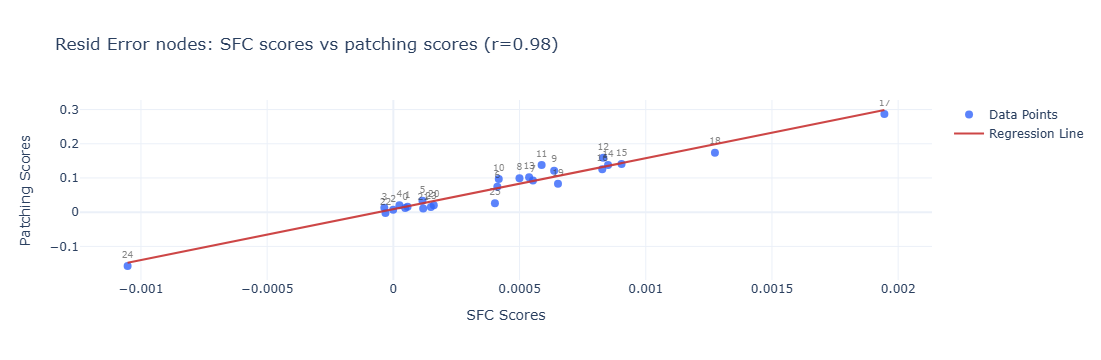

In [49]:
plot_correlation(resid_sfc_values, resid_patching_values)

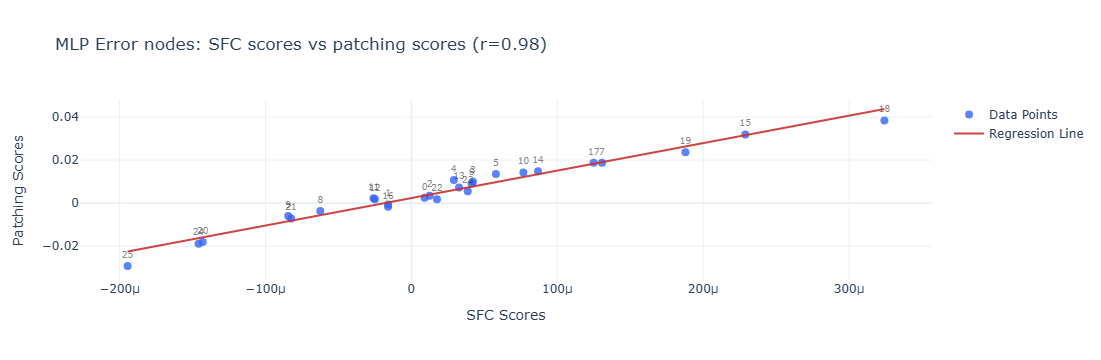

In [51]:
plot_correlation(mlp_sfc_values, mlp_patching_values, node_type='MLP')

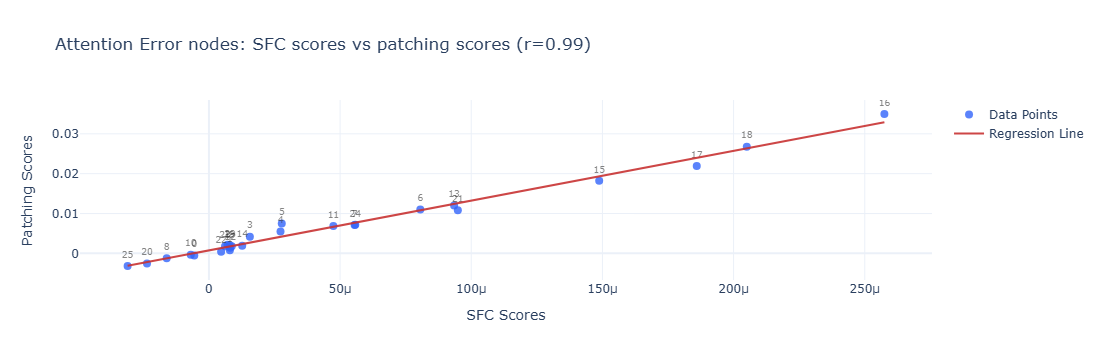

In [52]:
plot_correlation(attn_sfc_values, attn_patching_values, node_type='Attention')